In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import os
from scipy.stats import weibull_min, genpareto, pareto, lognorm, kstest, expon, probplot, poisson, gamma, lognorm, anderson
from sklearn.model_selection import train_test_split

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from IPython.display import display, Math

sns.set_theme(font_scale=1.2,
        style="ticks",
        rc={
        "text.usetex": True,
        'text.latex.preamble': r'\usepackage{amsfonts}\usepackage{graphicx}',
        "font.family": "serif",
    })

In [2]:
def load_csv_files_to_dataframe(directory, columns=None):
    """
    Reads all CSV files in the specified directory and combines them into a single pandas DataFrame.

    Parameters:
        directory (str): The path to the directory containing the CSV files.

    Returns:
        pd.DataFrame: A DataFrame containing the combined data from all CSV files.
    """
    # List to store dataframes
    dataframes = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):   
            if "random" in filename:
                continue
            filepath = os.path.join(directory, filename)
            print(f"Loading file: {filepath}")
            # Read the CSV file and append to the list
            dataframes.append(pd.read_csv(filepath, usecols=columns))

    # Concatenate all dataframes into one
    combined_dataframe = pd.concat(dataframes, ignore_index=True)
    return combined_dataframe

In [3]:
def get_repeated_video_counts(flag_status):

    # Step 2: **Exclude cases where a video was watched only once**
    flag_status = flag_status[flag_status["count"] > 1].copy()
    
    # Step 2: Classify video flagging behaviors
    conditions = [
        (flag_status["first"] == 0) & (flag_status["first_repeat"] == 0),  # Not Flagged → Seen Again → Not Flagged
        (flag_status["first"] == 1) & (flag_status["first_repeat"] == 0),  # Flagged → Seen Again → Not Flagged
        (flag_status["first"] == 0) & (flag_status["first_repeat"] == 1),  # Not Flagged → Seen Again → Flagged
        (flag_status["first"] == 1) & (flag_status["first_repeat"] == 1)   # Flagged → Seen Again → Flagged
    ]
    
    labels = [r"Not Flagged $\rightarrow$ Not Flagged", r"Flagged $\rightarrow$ Not Flagged", r"Not Flagged $\rightarrow$ Flagged", r"Flagged $\rightarrow$ Flagged"]
    flag_status["Behaviour"] = np.select(conditions, labels, default="Other")
    
    # Step 5: Compute the average fraction_play_time per user
    user_avg_playtime = flag_status.reset_index().groupby(["user_id", "Behaviour"])["play_time_1st"].mean().reset_index()

    return user_avg_playtime

In [4]:
full_df = load_csv_files_to_dataframe("KuaiRand-Harm/data", ["play_time_ms", "is_hate", "duration_ms", "video_id", "user_id", "date", "hourmin", "time_ms"])

Loading file: KuaiRand-Harm/data/log_standard_4_08_to_4_21_27k_part2.csv
Loading file: KuaiRand-Harm/data/log_standard_4_08_to_4_21_27k_part1.csv
Loading file: KuaiRand-Harm/data/log_standard_4_22_to_5_08_27k_part1.csv
Loading file: KuaiRand-Harm/data/log_standard_4_22_to_5_08_27k_part2.csv


In [5]:
dt = pd.to_datetime(full_df["time_ms"], unit='ms').dt.tz_localize('Asia/Singapore').dt.tz_convert("ETC/GMT-8")
full_df["timestamp"] = dt
full_df.drop(columns=["date", "hourmin", "time_ms"], inplace=True)

# Filter a bit to ensure we have reasonable data
original_size = len(full_df)
print("Total interaction size: ", len(full_df))

# Keep only elements with a duration greater than zero.
full_df = full_df[full_df.duration_ms > 0]
full_df["fraction_play_time"] = full_df.play_time_ms/full_df.duration_ms

# Remove users which now do not have any negative video flagged
harmful_users = full_df[full_df['is_hate'] == 1]['user_id'].unique()
full_df = full_df[full_df['user_id'].isin(harmful_users)]

reduction_size = len(full_df)
print("Final interaction size: ", len(full_df))
print("Reduction", 1-reduction_size/original_size) # We basically loose around 12 % of interactions
print("Unique videos: ", len(full_df.video_id.unique()))

Total interaction size:  63829631
Final interaction size:  56379526
Reduction 0.11671859735488677
Unique videos:  9857541


In [6]:
full_df['duration_seconds'] = round(full_df['duration_ms']/1000, 0)
full_df['play_time_seconds'] = round(full_df['play_time_ms']/1000, 0)
full_df["Reported"] = full_df["is_hate"].map({0: "No", 1: "Yes"})
full_df["play_time_seconds_no_rounding"] = full_df["play_time_ms"]/1000

In [7]:
## TABLE 1 ANALYSIS
average_is_hate = full_df.groupby(["user_id"])["is_hate"].mean().reset_index()
ecdf_x, ecdf_y = st.ecdf(average_is_hate["is_hate"].values*100).cdf.quantiles, st.ecdf(average_is_hate["is_hate"].values*100).cdf.probabilities

total = 0
for lower_bound, upper_bound in [(0, 0.1), (0.1, 0.3), (0.3, 1), (1, 100)]:
    
    ecdf_value = ecdf_y[(ecdf_x <= upper_bound)][-1]
    number_users = len(average_is_hate[(average_is_hate.is_hate*100 >= lower_bound) & (average_is_hate.is_hate*100 < upper_bound)])
    average_users = number_users/len(average_is_hate)
    
    print(f"${lower_bound} \leq H < {upper_bound} $", '\t', number_users, '\t', round(average_users, 3), '\t', round(ecdf_value, 3))
    total += number_users

print()
print("Kuaishou Video length: ", full_df['duration_seconds'].mean(), full_df['duration_seconds'].std())
print("User Dwell time: ", full_df['play_time_seconds'].mean(), full_df['play_time_seconds'].std())
print("Kuaishou Video length (median): ", full_df['duration_seconds'].median())
print("User Dwell time (median): ", full_df['play_time_seconds'].median())

$0 \leq H < 0.1 $ 	 4569 	 0.601 	 0.601
$0.1 \leq H < 0.3 $ 	 1909 	 0.251 	 0.852
$0.3 \leq H < 1 $ 	 827 	 0.109 	 0.961
$1 \leq H < 100 $ 	 296 	 0.039 	 1.0

Kuaishou Video length:  77.12670218263276 104.22625927023087
User Dwell time:  14.878583636903935 32.82713268025447
Kuaishou Video length (median):  36.0
User Dwell time (median):  3.0


In [8]:
user_average_watch_time = full_df.groupby(["user_id", "Reported"])["play_time_seconds"].mean().reset_index()

In [9]:
print("Users which on average does not watch reported videos")
for reported in ["Yes", "No"]:
    condition = (user_average_watch_time.play_time_seconds == 0) & (user_average_watch_time.Reported == reported)
    users_who_do_not_watch_videos = user_average_watch_time[condition]
    print(f"Reported = {reported}", '\t', 100*len(users_who_do_not_watch_videos)/len(user_average_watch_time.user_id.unique()), "%")

print()
print("Percentage of reported videos (H=1) with zero watch-time")
print(100*len(full_df[(full_df.play_time_seconds == 0) & (full_df.Reported == "Yes")])/len(full_df[(full_df.Reported == "Yes")]))

Users which on average does not watch reported videos
Reported = Yes 	 8.814629653992895 %
Reported = No 	 0.0 %

Percentage of reported videos (H=1) with zero watch-time
17.095006132333683


In [39]:
# Now, we separate repeated and non-repeated videos
full_df = full_df.sort_values(by=["user_id", "video_id", "timestamp"])

# Create DataFrame with only the first repeated occurrences
repeated_videos = full_df[full_df.duplicated(subset=["user_id", "video_id"], keep=False)].groupby(["user_id", "video_id"]).nth(1).reset_index()

# Create DataFrame with videos seen only once
seen_once_videos = full_df.drop_duplicates(subset=["user_id", "video_id"], keep="first")

In [12]:
# Find common (user_id, video_id) pairs
common_pairs = seen_once_videos[['user_id', 'video_id']].merge(repeated_videos[['user_id', 'video_id']], on=['user_id', 'video_id'])

# Filter both DataFrames to keep only common pairs
tmp2 = seen_once_videos.merge(common_pairs, on=['user_id', 'video_id'])
df2 = repeated_videos.merge(common_pairs, on=['user_id', 'video_id'])

# Merge filtered DataFrames
merged_df = pd.merge(tmp2, df2[["user_id", "video_id", "is_hate", "fraction_play_time", 'play_time_ms', 'play_time_seconds', 'play_time_seconds_no_rounding']], on=['user_id', 'video_id'])
del tmp2, df2, common_pairs

In [13]:
# Step 2: Classify video flagging behaviors
conditions = [
    (merged_df["is_hate_x"] == 0) & (merged_df["is_hate_y"] == 0),  # Not Flagged → Seen Again → Not Flagged
    (merged_df["is_hate_x"] == 1) & (merged_df["is_hate_y"] == 0),  # Flagged → Seen Again → Not Flagged
    (merged_df["is_hate_x"] == 0) & (merged_df["is_hate_y"] == 1),  # Not Flagged → Seen Again → Flagged
    (merged_df["is_hate_x"] == 1) & (merged_df["is_hate_y"] == 1)   # Flagged → Seen Again → Flagged
]

labels = [r"Not Flagged $\rightarrow$ Not Flagged", r"Flagged $\rightarrow$ Not Flagged", r"Not Flagged $\rightarrow$ Flagged", r"Flagged $\rightarrow$ Flagged"]
merged_df["Behaviour"] = np.select(conditions, labels, default="Other")

In [14]:
## TABLE 2 ANALYSIS

print("% of repeated videos", 100*len(merged_df)/len(full_df))
print("% of videos that get flagged: ", 100*len(seen_once_videos[(seen_once_videos.is_hate==1)])/len(seen_once_videos))
print("% of videos that get flagged (then repeated): ", 100*len(merged_df[(merged_df.is_hate_x==1)])/len(merged_df))
print("% of videos with H_0=0 that get flagged: ", 100*len(merged_df[(merged_df.is_hate_y==1) & (merged_df.is_hate_x==0)])/len(merged_df[(merged_df.is_hate_x==0)]))

total = 0
print()
print("Table 2")
for label in labels:
    current_label_df = merged_df[merged_df["Behaviour"] == label].copy()
    current_label_df["play_time_seconds_x"] = current_label_df["play_time_ms_x"]/1000
    current_label_df["play_time_seconds_y"] = current_label_df["play_time_ms_y"]/1000
    users_with_this_label = len(current_label_df.user_id.unique())
    watch_time_mean = current_label_df.play_time_seconds_x.mean()
    watch_time_std = current_label_df.play_time_seconds_x.std()
    watch_time_mean_second = current_label_df.play_time_seconds_y.mean()
    watch_time_std_second = current_label_df.play_time_seconds_y.std()

    watch_time_median = current_label_df.play_time_seconds_x.quantile(0.75)
    watch_time_median_second = current_label_df.play_time_seconds_y.quantile(0.75)
    
    print(
        label, '\t',
        round(100*len(current_label_df)/len(merged_df), 2), '\t',
        round(100*users_with_this_label/len(merged_df.user_id.unique()), 2), '\t',
        f"${round(watch_time_mean, 2)}\pm \scriptstyle {round(watch_time_std, 2)} \;\; ({round(watch_time_median, 2)})$", '\t',
        f"${round(watch_time_mean_second, 2)}\pm \scriptstyle {round(watch_time_std_second, 2)} \;\; ({round(watch_time_median_second, 2)})$"
    )
    total += len(current_label_df)/len(merged_df)

del current_label_df

% of repeated videos 2.642796251958557
% of videos that get flagged:  0.25853385490869496
% of videos that get flagged (then repeated):  0.10194658240693263
% of videos with H_0=0 that get flagged:  0.10870171322768171

Table 2
Not Flagged $\rightarrow$ Not Flagged 	 99.79 	 100.0 	 $2.71\pm \scriptstyle 12.15 \;\; (1.39)$ 	 $10.48\pm \scriptstyle 25.85 \;\; (7.95)$
Flagged $\rightarrow$ Not Flagged 	 0.03 	 1.49 	 $1.36\pm \scriptstyle 6.91 \;\; (0.0)$ 	 $6.46\pm \scriptstyle 25.42 \;\; (2.5)$
Not Flagged $\rightarrow$ Flagged 	 0.11 	 8.69 	 $0.5\pm \scriptstyle 7.41 \;\; (0.0)$ 	 $10.73\pm \scriptstyle 20.85 \;\; (10.13)$
Flagged $\rightarrow$ Flagged 	 0.07 	 6.33 	 $7.74\pm \scriptstyle 15.83 \;\; (6.64)$ 	 $7.85\pm \scriptstyle 15.86 \;\; (6.72)$


In [15]:
user_flag_ratio = seen_once_videos.groupby('user_id').agg(
    total_videos=('video_id', 'count'),
    flagged_videos=('is_hate', 'sum')
)

# Calculate the flagged ratio
user_flag_ratio['flag_ratio'] = user_flag_ratio['flagged_videos'] / user_flag_ratio['total_videos']

# Get the top 50 users by decreasing flagged ratio
top_50_users = user_flag_ratio.sort_values('flag_ratio', ascending=False).head(100).reset_index()

tmp = seen_once_videos[seen_once_videos.user_id.isin(top_50_users.user_id.values)]

639643 861848
    user_id  total_videos  flagged_videos  flag_ratio
0     19048          5238            3419    0.652730
1     15859         14369            6025    0.419305
2     17168          2935            1114    0.379557
3      4996         12924            3307    0.255881
4     10933          2332             565    0.242281
..      ...           ...             ...         ...
95    15947          1878              50    0.026624
96     2468           716              19    0.026536
97     6410          3831             101    0.026364
98    18712          5661             147    0.025967
99     9996          4587             118    0.025725

[100 rows x 4 columns]


7.406484375


/tmp/ipykernel_2847706/904730458.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["No", "Yes"])
/tmp/ipykernel_2847706/904730458.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(["None", r"$0\%$", r"$1\%$", r"$10\%$", r"$50\%$"])


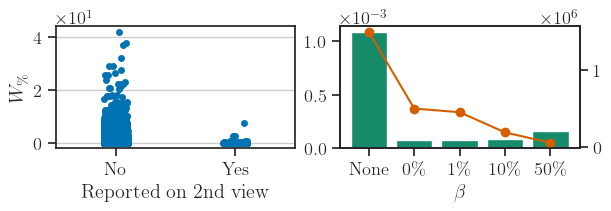

In [18]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True)

condition = (merged_df.Behaviour.isin([r"Not Flagged $\rightarrow$ Flagged",  r"Not Flagged $\rightarrow$ Not Flagged"]))

sns.stripplot(data=merged_df[condition],
             x="Behaviour",
             y="fraction_play_time_x",
             #y="play_time_seconds_x",
             ax=axs[0],
             legend=False,
             color=sns.color_palette("colorblind")[0],
             zorder=1,
            )

sns.barplot(
    data=likelihood_beta,
    x="beta",
    y="harm",
    ax=axs[1],
    color=sns.color_palette("colorblind")[2],
)

# Compute y-threshold for shading
y_threshold = merged_df[merged_df.Behaviour == r"Not Flagged $\rightarrow$ Flagged"].fraction_play_time_x.max()

# Custom legend handles
legend_patches = [
    #mpatches.Patch(color=sns.color_palette()[2], label="1st view"),
    #mpatches.Patch(color=sns.color_palette()[0], label="2nd view"),
    Line2D([0], [0], color="black", linestyle="--", label=r"$\beta^*$"),
]

axs[0].set_xlabel("Reported on 2nd view")
axs[0].set_xticklabels(["No", "Yes"])
axs[0].set_ylabel(r"$W_{\%}$")
axs[0].grid(axis="y")

axs[1].set_ylabel(None)
axs[1].set_xticklabels(["None", r"$0\%$", r"$1\%$", r"$10\%$", r"$50\%$"])
axs[1].set_xlabel(r"$\beta$")

axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax2 = axs[1].twinx()
x_positions = [p.get_x() + p.get_width() / 2 for p in axs[1].patches]
ax2.plot(x_positions, likelihood_beta['available'], marker='o', color=sns.color_palette("colorblind")[3])

plt.savefig("015_beta_repeated_videos.png", format="png", bbox_inches='tight', dpi=600)

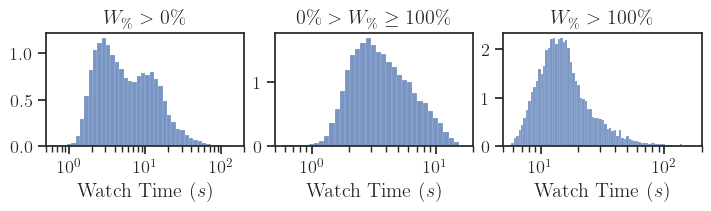

In [22]:
# We consider only videos with a duration between 7 and 12 seconds, since those are the most frequent ones.
# Then, we show how with a watchtime between 0 and 1, they behave as a log-normal (with a little tail on the left
# Then, for watch time > 1 they behave like a weibull/exponential

fig, axs = plt.subplots(1, 3, figsize=(7, 2), constrained_layout=True)

g = sns.histplot(seen_once_videos[(seen_once_videos.is_hate==1) & (seen_once_videos.duration_seconds >= 6) & (seen_once_videos.duration_seconds <= 15)],
                x="play_time_seconds_no_rounding",
                bins=100,
                log_scale=True,
                legend=True,
                stat="density",
                ax=axs[0])
g = sns.histplot(seen_once_videos[(seen_once_videos.is_hate==1) & (seen_once_videos.fraction_play_time > 0) & (seen_once_videos.fraction_play_time <= 1) & (seen_once_videos.duration_seconds >= 6) & (seen_once_videos.duration_seconds <= 15)],
                x="play_time_seconds_no_rounding",
                bins=100,
                log_scale=True,
                legend=True,
                stat="density",
                ax=axs[1])
g = sns.histplot(seen_once_videos[(seen_once_videos.is_hate==1) & (seen_once_videos.fraction_play_time > 1) & (seen_once_videos.duration_seconds >= 6) & (seen_once_videos.duration_seconds <= 15)],
                x="play_time_seconds_no_rounding",
                bins=100,
                log_scale=True,
                legend=True,
                stat="density",
                ax=axs[2])


axs[0].set_xlim(0.5, 200)
axs[0].set_ylabel("")
axs[0].set_xlabel(r"Watch Time ($s$)")
axs[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

axs[2].set_xlim(5, 200)
axs[2].set_ylabel("")
axs[2].set_xlabel(r"Watch Time ($s$)")
axs[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

axs[1].set_xlim(0.5, 20)
axs[1].set_ylabel("")
axs[1].set_xlabel(r"Watch Time ($s$)")
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

axs[0].set_title(r"$W_{\%} > 0\% $")
axs[1].set_title(r"$0\% > W_{\%} \geq 100\%$")
axs[2].set_title(r"$ W_{\%} > 100\%$")

plt.savefig("011_dwell_time_6-12.pdf", format="pdf", bbox_inches='tight')

0.21178482493442458


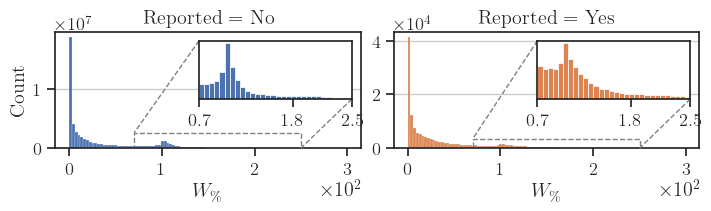

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, axs = plt.subplots(1, 2, figsize=(7, 2), constrained_layout=True)

plot_data = seen_once_videos

# Define the main condition
condition = (plot_data.fraction_play_time >= 0) & (plot_data.fraction_play_time < 3)

print(len(plot_data[condition & (plot_data.fraction_play_time == 0)])/len(plot_data[condition]))

# Create the main plot
g = sns.histplot(plot_data[condition & (plot_data.is_hate == 0)],
                x="fraction_play_time",
                bins=100,
                kde=False,
                log_scale=False,
                legend=True,
                stat="count",
                label="No",
               ax=axs[0])

g = sns.histplot(plot_data[condition & (plot_data.is_hate == 1)],
                x="fraction_play_time",
                bins=100,
                kde=False,
                log_scale=False,
                legend=True,
                stat="count",
                 label="Yes",
               ax=axs[1])

# Loop through each subplot to add an inset
for ax, col_val, color in zip(axs, [0, 1], sns.color_palette()[:2]):  # Iterate over FacetGrid axes

    for artist in ax.patches:  # Change histogram bars color
        artist.set_facecolor(color)
    for line in ax.lines:  # Change KDE color
        line.set_color(color)
    
    inset_ax = inset_axes(ax, width="50%", height="50%", loc="upper right")  # Create inset

    ax.set_title(f"Reported = {'Yes' if col_val == 1 else 'No'}")
    ax.set_xlabel(r"$W_{\%}$")
    ax.text(0.87, -0.35, r'$\times 10^2$', transform=ax.transAxes,
        ha='left', va='center')
    ax.grid(axis="y")
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    # Define the condition for the inset
    inset_condition = ((plot_data.fraction_play_time >= 0.7) & (plot_data.fraction_play_time < 2.5) & 
                       (plot_data.is_hate == col_val))  # Ensure same "is_hate" category
    
    # Plot the same data but within the restricted range
    sns.histplot(plot_data[inset_condition],
                 x="fraction_play_time",
                 bins=30,
                 ax=inset_ax)
    
    for artist in inset_ax.patches:  # Change histogram bars color
        artist.set_facecolor(color)
    for line in inset_ax.lines:  # Change KDE color
        line.set_color(color)
    
    inset_ax.set_xlim(0.7, 2.5)  # Restrict the x-axis to match the range
    inset_ax.set_xticks([0.7, 1.8, 2.5])  # Adjust x-ticks for readability
    inset_ax.set_yticks([])  # Hide y-ticks for a cleaner look
    inset_ax.set_xlabel("")
    inset_ax.set_ylabel("")

    # Add zoom effect with connecting lines
    mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5", linestyle="--")

axs[1].set_ylabel("")

plt.savefig("012_repeated_videos_watch_time.pdf", format="pdf", bbox_inches='tight')